In [1]:
# Gerekli kütüphaneleri import edelim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import mlflow
import mlflow.sklearn
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

print("📦 Tüm kütüphaneler başarıyla yüklendi!")
print("🚀 Model Development eğitimine hazırız!")


📦 Tüm kütüphaneler başarıyla yüklendi!
🚀 Model Development eğitimine hazırız!


In [2]:
# California housing veri setini yükleyelim
from sklearn.datasets import fetch_california_housing

# Veri setini yükle
california_housing = fetch_california_housing()
X = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
y = california_housing.target

print("🏠 California Housing Veri Seti Yüklendi!")
print(f"📊 Veri boyutu: {X.shape}")
print(f"🎯 Hedef değişken: Ev fiyatları (hundreds of thousands of dollars)")

# Veri setini inceleyelim
print("\n📋 Feature'lar:")
for i, feature in enumerate(california_housing.feature_names):
    print(f"  {i+1}. {feature}")

print(f"\n📈 İlk 5 satır:")
print(X.head())

print(f"\n📊 Temel istatistikler:")
print(X.describe())

print(f"\n🎯 Hedef değişken istatistikleri:")
print(f"Ortalama: ${y.mean():.2f}00k")
print(f"Medyan: ${np.median(y):.2f}00k") 
print(f"Min: ${y.min():.2f}00k")
print(f"Max: ${y.max():.2f}00k")


🏠 California Housing Veri Seti Yüklendi!
📊 Veri boyutu: (20640, 8)
🎯 Hedef değişken: Ev fiyatları (hundreds of thousands of dollars)

📋 Feature'lar:
  1. MedInc
  2. HouseAge
  3. AveRooms
  4. AveBedrms
  5. Population
  6. AveOccup
  7. Latitude
  8. Longitude

📈 İlk 5 satır:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  

📊 Temel istatistikler:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.00

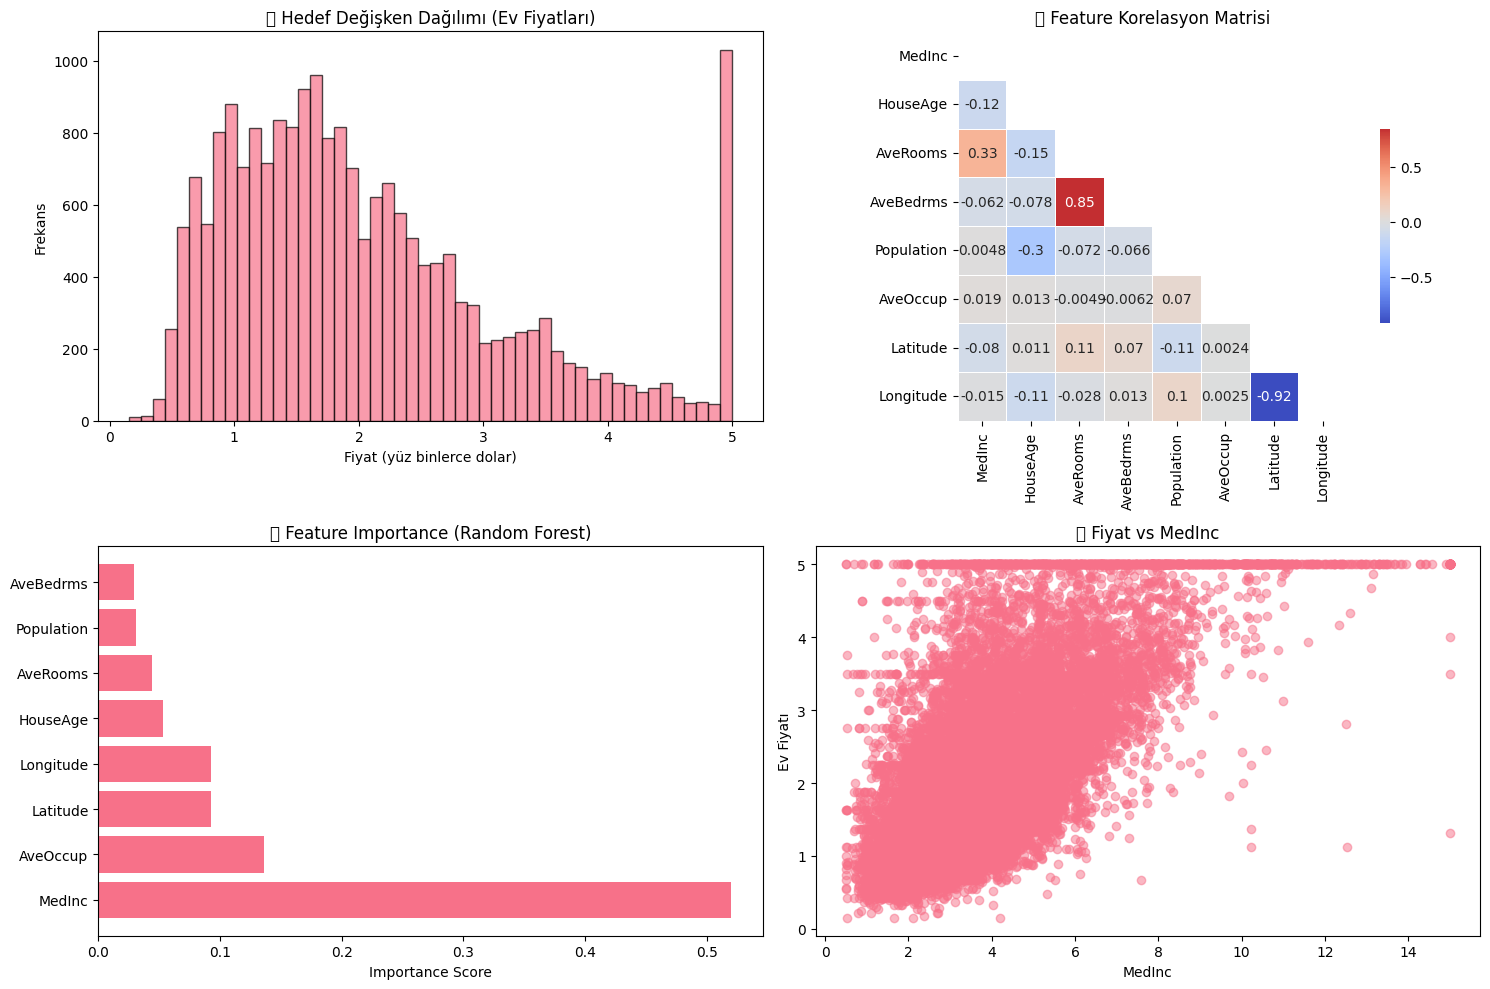


🏆 En önemli feature: MedInc
📊 Feature importance sıralaması:
  1. MedInc: 0.5200
  2. AveOccup: 0.1364
  3. Latitude: 0.0929
  4. Longitude: 0.0927
  5. HouseAge: 0.0530
  6. AveRooms: 0.0445
  7. Population: 0.0312
  8. AveBedrms: 0.0293


In [3]:
# Veri görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Hedef değişken dağılımı
axes[0, 0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('🎯 Hedef Değişken Dağılımı (Ev Fiyatları)')
axes[0, 0].set_xlabel('Fiyat (yüz binlerce dolar)')
axes[0, 0].set_ylabel('Frekans')

# Feature'ların korelasyonu
correlation_matrix = X.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .5}, ax=axes[0, 1])
axes[0, 1].set_title('🔗 Feature Korelasyon Matrisi')

# Feature importance (ilk bakış için)
from sklearn.ensemble import RandomForestRegressor
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_temp.fit(X, y)
feature_importance = pd.Series(rf_temp.feature_importances_, index=X.columns).sort_values(ascending=False)

axes[1, 0].barh(range(len(feature_importance)), feature_importance.values)
axes[1, 0].set_yticks(range(len(feature_importance)))
axes[1, 0].set_yticklabels(feature_importance.index)
axes[1, 0].set_title('📊 Feature Importance (Random Forest)')
axes[1, 0].set_xlabel('Importance Score')

# Hedef değişken vs en önemli feature
most_important_feature = feature_importance.index[0]
axes[1, 1].scatter(X[most_important_feature], y, alpha=0.5)
axes[1, 1].set_title(f'🎯 Fiyat vs {most_important_feature}')
axes[1, 1].set_xlabel(most_important_feature)
axes[1, 1].set_ylabel('Ev Fiyatı')

plt.tight_layout()
plt.show()

print(f"\n🏆 En önemli feature: {most_important_feature}")
print(f"📊 Feature importance sıralaması:")
for i, (feature, importance) in enumerate(feature_importance.items(), 1):
    print(f"  {i}. {feature}: {importance:.4f}")


In [4]:
class ModelComparisonFramework:
    """Model karşılaştırma ve değerlendirme framework'ü"""
    
    def __init__(self, X, y, test_size=0.2, random_state=42):
        self.X = X
        self.y = y
        self.random_state = random_state
        
        # Veri setini böl
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Veri ölçeklendirme
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # Sonuçları saklamak için
        self.results = {}
        self.models = {}
        
        print(f"📊 Veri seti bölündü:")
        print(f"  • Training: {self.X_train.shape[0]} sample")
        print(f"  • Test: {self.X_test.shape[0]} sample")
    
    def add_model(self, name, model, use_scaling=False):
        """Model ekle"""
        self.models[name] = {
            'model': model,
            'use_scaling': use_scaling
        }
        print(f"✅ {name} modeli eklendi")
    
    def evaluate_model(self, name, cv_folds=5):
        """Model değerlendirmesi yap"""
        model_config = self.models[name]
        model = model_config['model']
        use_scaling = model_config['use_scaling']
        
        # Uygun veri setini seç
        if use_scaling:
            X_train = self.X_train_scaled
            X_test = self.X_test_scaled
        else:
            X_train = self.X_train
            X_test = self.X_test
        
        # Model eğitimi
        model.fit(X_train, self.y_train)
        
        # Tahminler
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Cross-validation
        if use_scaling:
            cv_scores = cross_val_score(model, self.X_train_scaled, self.y_train, 
                                      cv=cv_folds, scoring='neg_mean_squared_error')
        else:
            cv_scores = cross_val_score(model, self.X_train, self.y_train, 
                                      cv=cv_folds, scoring='neg_mean_squared_error')
        
        # Metrikleri hesapla
        results = {
            'train_rmse': np.sqrt(mean_squared_error(self.y_train, y_train_pred)),
            'test_rmse': np.sqrt(mean_squared_error(self.y_test, y_test_pred)),
            'train_mae': mean_absolute_error(self.y_train, y_train_pred),
            'test_mae': mean_absolute_error(self.y_test, y_test_pred),
            'train_r2': r2_score(self.y_train, y_train_pred),
            'test_r2': r2_score(self.y_test, y_test_pred),
            'cv_rmse_mean': np.sqrt(-cv_scores.mean()),
            'cv_rmse_std': np.sqrt(cv_scores.std()),
            'overfitting': np.sqrt(mean_squared_error(self.y_train, y_train_pred)) - np.sqrt(mean_squared_error(self.y_test, y_test_pred))
        }
        
        self.results[name] = results
        return results
    
    def evaluate_all_models(self, cv_folds=5):
        """Tüm modelleri değerlendir"""
        print("🔄 Tüm modeller değerlendiriliyor...\n")
        
        for name in self.models.keys():
            print(f"📊 {name} değerlendiriliyor...")
            results = self.evaluate_model(name, cv_folds)
            print(f"  ✅ Test RMSE: {results['test_rmse']:.4f}")
            print(f"  ✅ Test R²: {results['test_r2']:.4f}")
            print()
        
        print("🎉 Tüm modeller değerlendirildi!")
    
    def get_comparison_dataframe(self):
        """Karşılaştırma tablosu oluştur"""
        if not self.results:
            print("❌ Henüz model değerlendirmesi yapılmamış!")
            return None
        
        df = pd.DataFrame(self.results).T
        df = df.sort_values('test_rmse')
        return df
    
    def plot_model_comparison(self):
        """Model karşılaştırma grafikleri"""
        if not self.results:
            print("❌ Henüz model değerlendirmesi yapılmamış!")
            return
        
        df = self.get_comparison_dataframe()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # RMSE karşılaştırması
        axes[0, 0].barh(df.index, df['test_rmse'])
        axes[0, 0].set_title('🎯 Test RMSE Karşılaştırması')
        axes[0, 0].set_xlabel('RMSE')
        
        # R² karşılaştırması
        axes[0, 1].barh(df.index, df['test_r2'])
        axes[0, 1].set_title('📊 Test R² Karşılaştırması')
        axes[0, 1].set_xlabel('R² Score')
        
        # Overfitting analizi
        axes[1, 0].barh(df.index, df['overfitting'])
        axes[1, 0].set_title('⚠️ Overfitting Analizi (Train RMSE - Test RMSE)')
        axes[1, 0].set_xlabel('Overfitting Score')
        axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)
        
        # Cross-validation sonuçları
        axes[1, 1].errorbar(df['cv_rmse_mean'], range(len(df)), 
                           xerr=df['cv_rmse_std'], fmt='o')
        axes[1, 1].set_yticks(range(len(df)))
        axes[1, 1].set_yticklabels(df.index)
        axes[1, 1].set_title('📈 Cross-Validation RMSE (Mean ± Std)')
        axes[1, 1].set_xlabel('CV RMSE')
        
        plt.tight_layout()
        plt.show()
    
    def get_best_model(self, metric='test_rmse'):
        """En iyi modeli bul"""
        if not self.results:
            print("❌ Henüz model değerlendirmesi yapılmamış!")
            return None
        
        df = self.get_comparison_dataframe()
        
        if metric in ['test_rmse', 'train_rmse', 'test_mae', 'train_mae']:
            best_model_name = df[metric].idxmin()
        else:  # R² gibi yüksek olması gereken metrikler
            best_model_name = df[metric].idxmax()
        
        print(f"🏆 En iyi model ({metric}): {best_model_name}")
        print(f"📊 Performans: {df.loc[best_model_name, metric]:.4f}")
        
        return best_model_name, self.models[best_model_name]['model']

# Framework'ü başlat
framework = ModelComparisonFramework(X, y, test_size=0.2, random_state=42)


📊 Veri seti bölündü:
  • Training: 16512 sample
  • Test: 4128 sample


In [5]:
# Farklı modelleri framework'e ekleyelim
print("🤖 Modeller ekleniyor...\n")

# 1. Basit modeller
framework.add_model("Linear Regression", LinearRegression(), use_scaling=True)
framework.add_model("Ridge Regression", Ridge(random_state=42), use_scaling=True)
framework.add_model("Lasso Regression", Lasso(random_state=42), use_scaling=True)

# 2. Tree-based modeller
framework.add_model("Decision Tree", DecisionTreeRegressor(random_state=42))
framework.add_model("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42))
framework.add_model("Gradient Boosting", GradientBoostingRegressor(random_state=42))

# 3. Diğer modeller
framework.add_model("K-Neighbors", KNeighborsRegressor(), use_scaling=True)
framework.add_model("SVR", SVR(), use_scaling=True)

print(f"\n✅ Toplam {len(framework.models)} model eklendi!")


🤖 Modeller ekleniyor...

✅ Linear Regression modeli eklendi
✅ Ridge Regression modeli eklendi
✅ Lasso Regression modeli eklendi
✅ Decision Tree modeli eklendi
✅ Random Forest modeli eklendi
✅ Gradient Boosting modeli eklendi
✅ K-Neighbors modeli eklendi
✅ SVR modeli eklendi

✅ Toplam 8 model eklendi!


In [6]:
# Tüm modelleri değerlendirelim
framework.evaluate_all_models(cv_folds=5)


🔄 Tüm modeller değerlendiriliyor...

📊 Linear Regression değerlendiriliyor...
  ✅ Test RMSE: 0.7456
  ✅ Test R²: 0.5758

📊 Ridge Regression değerlendiriliyor...
  ✅ Test RMSE: 0.7456
  ✅ Test R²: 0.5758

📊 Lasso Regression değerlendiriliyor...
  ✅ Test RMSE: 1.1449
  ✅ Test R²: -0.0002

📊 Decision Tree değerlendiriliyor...
  ✅ Test RMSE: 0.7037
  ✅ Test R²: 0.6221

📊 Random Forest değerlendiriliyor...
  ✅ Test RMSE: 0.5053
  ✅ Test R²: 0.8051

📊 Gradient Boosting değerlendiriliyor...
  ✅ Test RMSE: 0.5422
  ✅ Test R²: 0.7756

📊 K-Neighbors değerlendiriliyor...
  ✅ Test RMSE: 0.6576
  ✅ Test R²: 0.6700

📊 SVR değerlendiriliyor...
  ✅ Test RMSE: 0.5975
  ✅ Test R²: 0.7276

🎉 Tüm modeller değerlendirildi!


📊 Model Karşılaştırma Sonuçları:
                   train_rmse  test_rmse  train_mae  test_mae  train_r2  \
Random Forest          0.1880     0.5053     0.1221    0.3275    0.9736   
Gradient Boosting      0.5107     0.5422     0.3566    0.3716    0.8049   
SVR                    0.5798     0.5975     0.3831    0.3986    0.7486   
K-Neighbors            0.5211     0.6576     0.3552    0.4462    0.7969   
Decision Tree          0.0000     0.7037     0.0000    0.4547    1.0000   
Ridge Regression       0.7197     0.7456     0.5286    0.5332    0.6126   
Linear Regression      0.7197     0.7456     0.5286    0.5332    0.6126   
Lasso Regression       1.1562     1.1449     0.9139    0.9061    0.0000   

                   test_r2  cv_rmse_mean  cv_rmse_std  overfitting  
Random Forest       0.8051        0.5115       0.0681      -0.3174  
Gradient Boosting   0.7756        0.5341       0.0874      -0.0315  
SVR                 0.7276        0.5932       0.1119      -0.0177  
K-Neighbors    

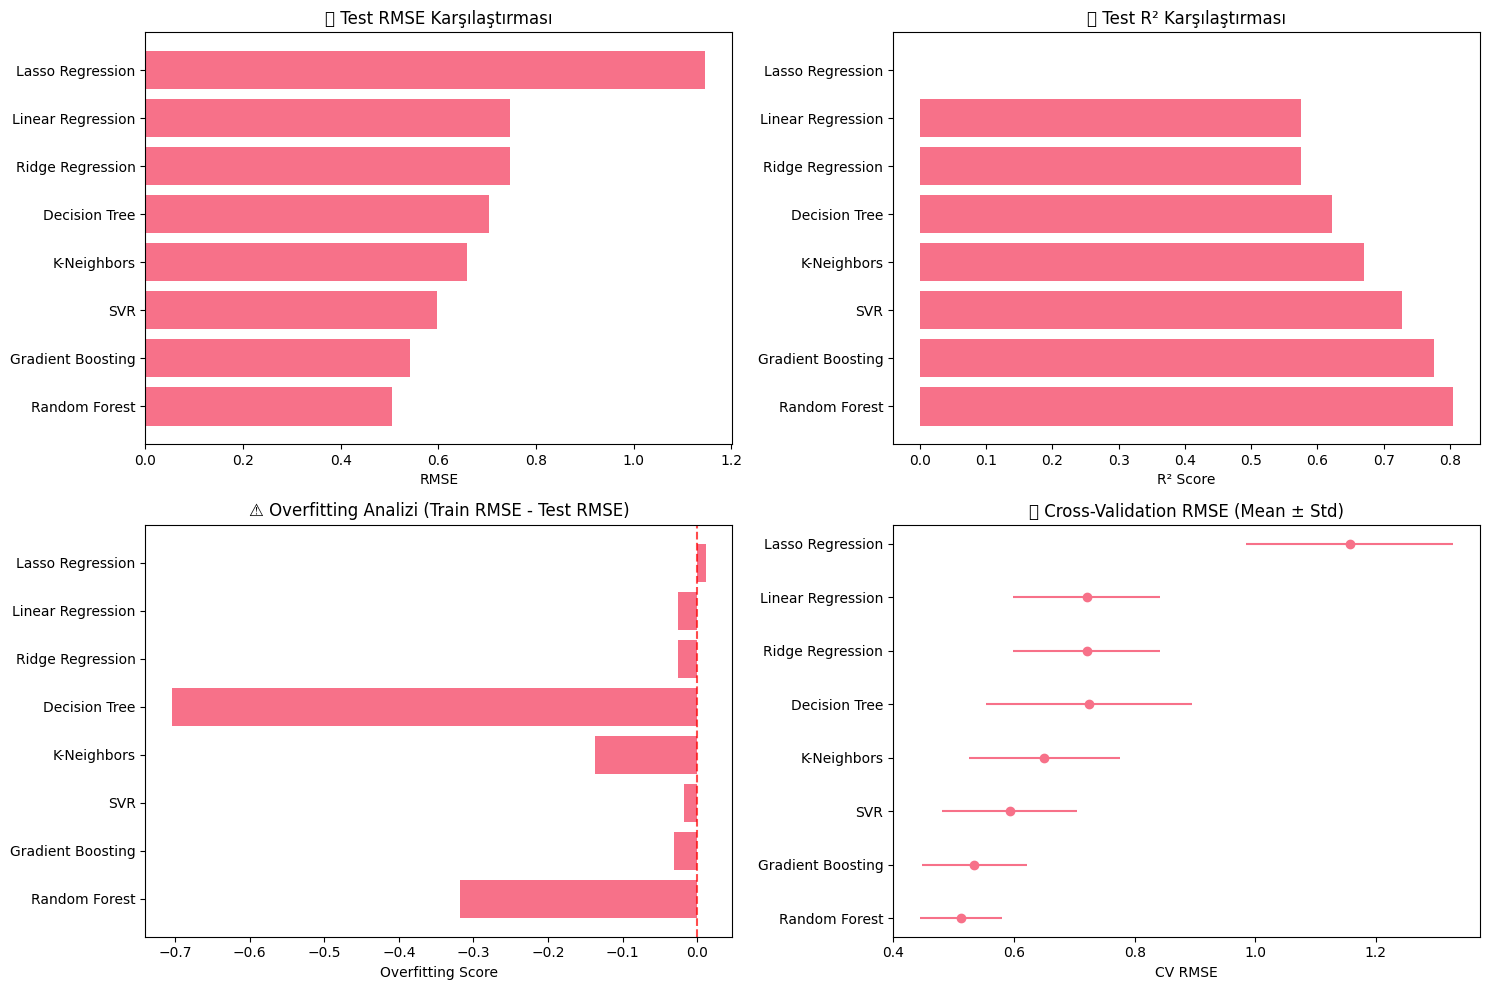

In [7]:
# Sonuçları görselleştirelim
print("📊 Model Karşılaştırma Sonuçları:")
print("="*50)

comparison_df = framework.get_comparison_dataframe()
print(comparison_df.round(4))

print(f"\n🏆 En iyi modeller:")
best_model_rmse = framework.get_best_model('test_rmse')
best_model_r2 = framework.get_best_model('test_r2')

# Görselleştirme
framework.plot_model_comparison()


In [10]:
class HyperparameterTuner:
    """Hyperparameter tuning için sınıf"""
    
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.tuned_models = {}
        self.best_params = {}
    
    def tune_random_forest(self, n_iter=50):
        """Random Forest hyperparameter tuning"""
        print("🌲 Random Forest tuning başlıyor...")
        
        # Parametre grid'i
        param_distributions = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True, False]
        }
        
        # RandomizedSearchCV
        rf = RandomForestRegressor(random_state=42)
        random_search = RandomizedSearchCV(
            rf, param_distributions, n_iter=n_iter, cv=5, 
            scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
        )
        
        random_search.fit(self.X_train, self.y_train)
        
        # En iyi model
        best_rf = random_search.best_estimator_
        self.tuned_models['Random Forest Tuned'] = best_rf
        self.best_params['Random Forest'] = random_search.best_params_
        
        # Performans değerlendirmesi
        y_pred = best_rf.predict(self.X_test)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        r2 = r2_score(self.y_test, y_pred)
        
        print(f"✅ Random Forest tuning tamamlandı!")
        print(f"📊 Test RMSE: {rmse:.4f}")
        print(f"📊 Test R²: {r2:.4f}")
        print(f"🔧 En iyi parametreler: {random_search.best_params_}")
        
        return best_rf
    
    def tune_gradient_boosting(self, n_iter=50):
        """Gradient Boosting hyperparameter tuning"""
        print("\n🚀 Gradient Boosting tuning başlıyor...")
        
        # Parametre grid'i
        param_distributions = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0]
        }
        
        # RandomizedSearchCV
        gb = GradientBoostingRegressor(random_state=42)
        random_search = RandomizedSearchCV(
            gb, param_distributions, n_iter=n_iter, cv=5,
            scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
        )
        
        random_search.fit(self.X_train, self.y_train)
        
        # En iyi model
        best_gb = random_search.best_estimator_
        self.tuned_models['Gradient Boosting Tuned'] = best_gb
        self.best_params['Gradient Boosting'] = random_search.best_params_
        
        # Performans değerlendirmesi
        y_pred = best_gb.predict(self.X_test)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        r2 = r2_score(self.y_test, y_pred)
        
        print(f"✅ Gradient Boosting tuning tamamlandı!")
        print(f"📊 Test RMSE: {rmse:.4f}")
        print(f"📊 Test R²: {r2:.4f}")
        print(f"🔧 En iyi parametreler: {random_search.best_params_}")
        
        return best_gb
    
    def tune_svr(self, n_iter=50):
        """SVR hyperparameter tuning (scaled data ile)"""
        print("\n🎯 SVR tuning başlıyor...")
        
        # Veri ölçeklendirme
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)
        
        # Parametre grid'i
        param_distributions = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
            'epsilon': [0.01, 0.1, 0.2, 0.5],
            'kernel': ['linear', 'rbf', 'poly']
        }
        
        # RandomizedSearchCV
        svr = SVR()
        random_search = RandomizedSearchCV(
            svr, param_distributions, n_iter=n_iter, cv=5,
            scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
        )
        
        random_search.fit(X_train_scaled, self.y_train)
        
        # En iyi model
        best_svr = random_search.best_estimator_
        self.tuned_models['SVR Tuned'] = best_svr
        self.best_params['SVR'] = random_search.best_params_
        
        # Performans değerlendirmesi
        y_pred = best_svr.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        r2 = r2_score(self.y_test, y_pred)
        
        print(f"✅ SVR tuning tamamlandı!")
        print(f"📊 Test RMSE: {rmse:.4f}")
        print(f"📊 Test R²: {r2:.4f}")
        print(f"🔧 En iyi parametreler: {random_search.best_params_}")
        
        return best_svr
    
    def get_tuned_models(self):
        """Tune edilmiş modelleri döndür"""
        return self.tuned_models

# Hyperparameter tuner'ı başlat
tuner = HyperparameterTuner(
    framework.X_train, framework.X_test, 
    framework.y_train, framework.y_test
)

# En iyi modelleri tune et
best_rf_tuned = tuner.tune_random_forest(n_iter=1)
best_gb_tuned = tuner.tune_gradient_boosting(n_iter=1)
best_svr_tuned = tuner.tune_svr(n_iter=1)


🌲 Random Forest tuning başlıyor...
✅ Random Forest tuning tamamlandı!
📊 Test RMSE: 0.5068
📊 Test R²: 0.8040
🔧 En iyi parametreler: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

🚀 Gradient Boosting tuning başlıyor...
✅ Gradient Boosting tuning tamamlandı!
📊 Test RMSE: 0.6215
📊 Test R²: 0.7052
🔧 En iyi parametreler: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.01}

🎯 SVR tuning başlıyor...
✅ SVR tuning tamamlandı!
📊 Test RMSE: 0.7611
📊 Test R²: 0.5580
🔧 En iyi parametreler: {'kernel': 'linear', 'gamma': 0.1, 'epsilon': 0.1, 'C': 1}


In [11]:
# Model Ensemble oluşturalım
print("🎭 Model Ensemble oluşturuluyor...\n")

# En iyi tune edilmiş modelleri alıyoruz
estimators = [
    ('rf', best_rf_tuned),
    ('gb', best_gb_tuned),
    ('ridge', Ridge(alpha=1.0))  # Basit bir model ekleyerek diversity sağlayalım
]

# Voting Regressor (ortalama tahmin)
voting_regressor = VotingRegressor(estimators=estimators)
voting_regressor.fit(framework.X_train, framework.y_train)

# Performans değerlendirmesi
y_pred_ensemble = voting_regressor.predict(framework.X_test)
ensemble_rmse = np.sqrt(mean_squared_error(framework.y_test, y_pred_ensemble))
ensemble_r2 = r2_score(framework.y_test, y_pred_ensemble)

print(f"🎯 Ensemble Model Performansı:")
print(f"📊 Test RMSE: {ensemble_rmse:.4f}")
print(f"📊 Test R²: {ensemble_r2:.4f}")

# Cross-validation ile ensemble performansını doğrulayalım
cv_scores_ensemble = cross_val_score(voting_regressor, framework.X_train, framework.y_train,
                                   cv=5, scoring='neg_mean_squared_error')
cv_rmse_ensemble = np.sqrt(-cv_scores_ensemble.mean())
cv_rmse_std_ensemble = np.sqrt(cv_scores_ensemble.std())

print(f"📈 CV RMSE: {cv_rmse_ensemble:.4f} ± {cv_rmse_std_ensemble:.4f}")

# Tekil modellerin performanslarını tekrar hesaplayalım ve karşılaştıralım
print(f"\n📊 Model Karşılaştırması:")
print("="*60)

models_to_compare = {
    'Random Forest (Tuned)': best_rf_tuned,
    'Gradient Boosting (Tuned)': best_gb_tuned,
    'Ensemble': voting_regressor
}

comparison_results = {}
for name, model in models_to_compare.items():
    if name == 'Ensemble':
        X_test_for_model = framework.X_test
    else:
        X_test_for_model = framework.X_test
    
    y_pred = model.predict(X_test_for_model)
    rmse = np.sqrt(mean_squared_error(framework.y_test, y_pred))
    r2 = r2_score(framework.y_test, y_pred)
    
    comparison_results[name] = {'RMSE': rmse, 'R²': r2}
    print(f"{name:25} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

print(f"\n🏆 En iyi model: {min(comparison_results.items(), key=lambda x: x[1]['RMSE'])[0]}")

# Ensemble'ın her bir bileşeninin ağırlığını gösterelim
print(f"\n⚖️ Ensemble Bileşenleri:")
for i, (name, _) in enumerate(estimators):
    print(f"  • {name}: {1/len(estimators):.3f} (eşit ağırlık)")


🎭 Model Ensemble oluşturuluyor...

🎯 Ensemble Model Performansı:
📊 Test RMSE: 0.5882
📊 Test R²: 0.7360
📈 CV RMSE: 0.5785 ± 0.0994

📊 Model Karşılaştırması:
Random Forest (Tuned)     - RMSE: 0.5068, R²: 0.8040
Gradient Boosting (Tuned) - RMSE: 0.6215, R²: 0.7052
Ensemble                  - RMSE: 0.5882, R²: 0.7360

🏆 En iyi model: Random Forest (Tuned)

⚖️ Ensemble Bileşenleri:
  • rf: 0.333 (eşit ağırlık)
  • gb: 0.333 (eşit ağırlık)
  • ridge: 0.333 (eşit ağırlık)


🔍 Feature Importance Analizi Başlıyor...

📊 Permutation Importance hesaplanıyor...


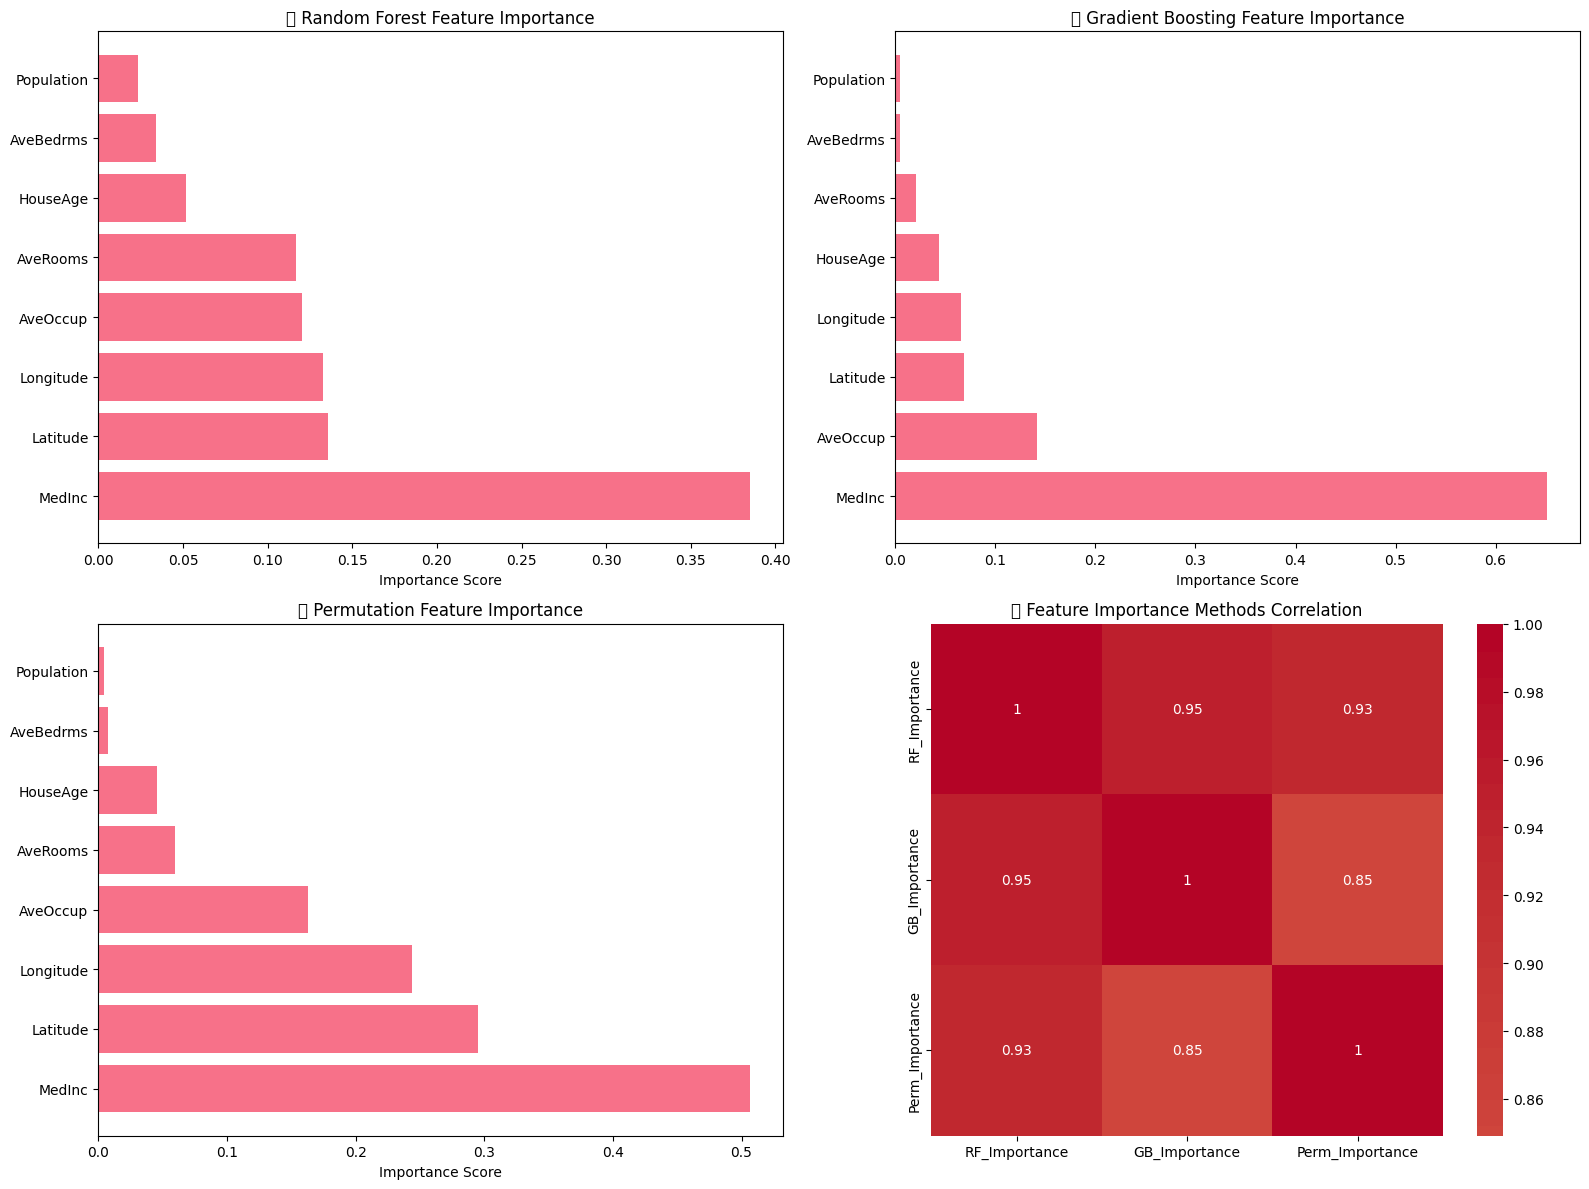


🏆 En Önemli Feature'lar:

📊 Random Forest Top 5:
  1. MedInc: 0.3852
  2. Latitude: 0.1355
  3. Longitude: 0.1327
  4. AveOccup: 0.1206
  5. AveRooms: 0.1169

📊 Gradient Boosting Top 5:
  1. MedInc: 0.6518
  2. AveOccup: 0.1415
  3. Latitude: 0.0681
  4. Longitude: 0.0656
  5. HouseAge: 0.0432

📊 Permutation Importance Top 5:
  1. MedInc: 0.5068 ± 0.0108
  2. Latitude: 0.2952 ± 0.0068
  3. Longitude: 0.2438 ± 0.0042
  4. AveOccup: 0.1629 ± 0.0040
  5. AveRooms: 0.0595 ± 0.0022

🎯 Feature Selection Önerisi:
En önemli 5 feature: ['MedInc', 'Latitude', 'Longitude', 'AveOccup', 'AveRooms']

📊 Feature Selection Sonuçları:
  • Orijinal (8 feature): RMSE = 0.5068
  • Seçilmiş (5 feature): RMSE = 0.4968
  • Performans farkı: -1.97%


In [12]:
# Feature Importance Analizi
print("🔍 Feature Importance Analizi Başlıyor...\n")

# 1. Random Forest Feature Importance
rf_feature_importance = pd.Series(
    best_rf_tuned.feature_importances_, 
    index=X.columns
).sort_values(ascending=False)

# 2. Permutation Importance (daha güvenilir)
print("📊 Permutation Importance hesaplanıyor...")
perm_importance = permutation_importance(
    best_rf_tuned, framework.X_test, framework.y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

# 3. Gradient Boosting Feature Importance
gb_feature_importance = pd.Series(
    best_gb_tuned.feature_importances_, 
    index=X.columns
).sort_values(ascending=False)

# Görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Random Forest Feature Importance
axes[0, 0].barh(range(len(rf_feature_importance)), rf_feature_importance.values)
axes[0, 0].set_yticks(range(len(rf_feature_importance)))
axes[0, 0].set_yticklabels(rf_feature_importance.index)
axes[0, 0].set_title('🌲 Random Forest Feature Importance')
axes[0, 0].set_xlabel('Importance Score')

# Gradient Boosting Feature Importance
axes[0, 1].barh(range(len(gb_feature_importance)), gb_feature_importance.values)
axes[0, 1].set_yticks(range(len(gb_feature_importance)))
axes[0, 1].set_yticklabels(gb_feature_importance.index)
axes[0, 1].set_title('🚀 Gradient Boosting Feature Importance')
axes[0, 1].set_xlabel('Importance Score')

# Permutation Importance
axes[1, 0].barh(range(len(perm_importance_df)), perm_importance_df['importance_mean'])
axes[1, 0].set_yticks(range(len(perm_importance_df)))
axes[1, 0].set_yticklabels(perm_importance_df['feature'])
axes[1, 0].set_title('🔄 Permutation Feature Importance')
axes[1, 0].set_xlabel('Importance Score')

# Feature importance karşılaştırması
comparison_df = pd.DataFrame({
    'RF_Importance': rf_feature_importance,
    'GB_Importance': gb_feature_importance,
    'Perm_Importance': perm_importance_df.set_index('feature')['importance_mean']
}).fillna(0)

# Korelasyon matrisi
correlation_importance = comparison_df.corr()
sns.heatmap(correlation_importance, annot=True, cmap='coolwarm', center=0, 
            square=True, ax=axes[1, 1])
axes[1, 1].set_title('🔗 Feature Importance Methods Correlation')

plt.tight_layout()
plt.show()

# En önemli feature'ları yazdır
print(f"\n🏆 En Önemli Feature'lar:")
print("="*50)
print(f"\n📊 Random Forest Top 5:")
for i, (feature, importance) in enumerate(rf_feature_importance.head().items(), 1):
    print(f"  {i}. {feature}: {importance:.4f}")

print(f"\n📊 Gradient Boosting Top 5:")
for i, (feature, importance) in enumerate(gb_feature_importance.head().items(), 1):
    print(f"  {i}. {feature}: {importance:.4f}")

print(f"\n📊 Permutation Importance Top 5:")
for i, row in enumerate(perm_importance_df.head().itertuples(), 1):
    print(f"  {i}. {row.feature}: {row.importance_mean:.4f} ± {row.importance_std:.4f}")

# Feature selection örneği
print(f"\n🎯 Feature Selection Önerisi:")
# En önemli 5 feature'ı seçelim
top_features = perm_importance_df.head(5)['feature'].tolist()
print(f"En önemli 5 feature: {top_features}")

# Bu feature'larla yeni bir model eğitelim
X_selected = framework.X_train[top_features]
X_test_selected = framework.X_test[top_features]

rf_selected = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selected.fit(X_selected, framework.y_train)

y_pred_selected = rf_selected.predict(X_test_selected)
rmse_selected = np.sqrt(mean_squared_error(framework.y_test, y_pred_selected))
r2_selected = r2_score(framework.y_test, y_pred_selected)

print(f"\n📊 Feature Selection Sonuçları:")
print(f"  • Orijinal (8 feature): RMSE = {np.sqrt(mean_squared_error(framework.y_test, best_rf_tuned.predict(framework.X_test))):.4f}")
print(f"  • Seçilmiş (5 feature): RMSE = {rmse_selected:.4f}")
print(f"  • Performans farkı: {((rmse_selected / np.sqrt(mean_squared_error(framework.y_test, best_rf_tuned.predict(framework.X_test)))) - 1) * 100:.2f}%")


In [13]:
# MLflow experiment setup
mlflow.set_experiment("california-housing-model-development")

# MLflow ile model kaydetme fonksiyonu
def log_model_to_mlflow(model, model_name, X_test, y_test, additional_params=None):
    """Model ve metriklerini MLflow'a kaydet"""
    with mlflow.start_run(run_name=model_name):
        # Tahminler
        y_pred = model.predict(X_test)
        
        # Metrikleri hesapla
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Metrikleri kaydet
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2_score", r2)
        mlflow.log_metric("test_samples", len(y_test))
        
        # Model parametrelerini kaydet
        if hasattr(model, 'get_params'):
            params = model.get_params()
            for param, value in params.items():
                if isinstance(value, (int, float, str, bool)):
                    mlflow.log_param(param, value)
        
        # Ek parametreler
        if additional_params:
            for param, value in additional_params.items():
                mlflow.log_param(param, value)
        
        # Model'i kaydet
        mlflow.sklearn.log_model(model, "model")
        
        print(f"✅ {model_name} MLflow'a kaydedildi!")
        print(f"  📊 RMSE: {rmse:.4f}")
        print(f"  📊 R²: {r2:.4f}")
        
        return mlflow.active_run().info.run_id

print("📝 Modeller MLflow'a kaydediliyor...\n")

# En iyi modelleri kaydet
run_ids = {}

# 1. Tuned Random Forest
print("🌲 Random Forest (Tuned) kaydediliyor...")
run_ids['rf_tuned'] = log_model_to_mlflow(
    best_rf_tuned, 
    "Random Forest Tuned",
    framework.X_test, 
    framework.y_test,
    additional_params={
        "tuning_method": "RandomizedSearchCV",
        "tuning_iterations": 30,
        "model_type": "tree_based"
    }
)

print()

# 2. Tuned Gradient Boosting
print("🚀 Gradient Boosting (Tuned) kaydediliyor...")
run_ids['gb_tuned'] = log_model_to_mlflow(
    best_gb_tuned,
    "Gradient Boosting Tuned", 
    framework.X_test,
    framework.y_test,
    additional_params={
        "tuning_method": "RandomizedSearchCV",
        "tuning_iterations": 30,
        "model_type": "boosting"
    }
)

print()

# 3. Ensemble Model
print("🎭 Ensemble Model kaydediliyor...")
run_ids['ensemble'] = log_model_to_mlflow(
    voting_regressor,
    "Voting Ensemble",
    framework.X_test,
    framework.y_test,
    additional_params={
        "ensemble_method": "VotingRegressor",
        "n_estimators": len(estimators),
        "model_type": "ensemble"
    }
)

print()

# 4. Feature Selected Model
print("🎯 Feature Selected Model kaydediliyor...")
run_ids['feature_selected'] = log_model_to_mlflow(
    rf_selected,
    "Random Forest (Feature Selected)",
    X_test_selected,
    framework.y_test,
    additional_params={
        "feature_selection": "permutation_importance",
        "n_features": len(top_features),
        "selected_features": str(top_features),
        "model_type": "tree_based"
    }
)

print(f"\n🎉 Tüm modeller MLflow'a kaydedildi!")
print(f"📊 Toplam {len(run_ids)} model kaydedildi")

# MLflow UI'yi başlatma talimatları
print(f"\n🌐 MLflow UI'yi görmek için:")
print("1. Terminal'de şu komutu çalıştırın: mlflow ui")
print("2. Tarayıcınızda http://localhost:5000 adresini açın")
print("3. 'california-housing-model-development' experiment'ini seçin")

# En iyi modeli seçelim
best_run_id = None
best_rmse = float('inf')

with mlflow.start_run(run_name="Model Comparison Summary"):
    # Tüm modellerin performansını karşılaştır ve kaydet
    model_comparison = {
        'Random Forest Tuned': np.sqrt(mean_squared_error(framework.y_test, best_rf_tuned.predict(framework.X_test))),
        'Gradient Boosting Tuned': np.sqrt(mean_squared_error(framework.y_test, best_gb_tuned.predict(framework.X_test))),
        'Ensemble': ensemble_rmse,
        'Feature Selected': rmse_selected
    }
    
    for model_name, rmse in model_comparison.items():
        mlflow.log_metric(f"{model_name}_rmse", rmse)
        if rmse < best_rmse:
            best_rmse = rmse
            best_model_name = model_name
    
    mlflow.log_param("best_model", best_model_name)
    mlflow.log_metric("best_rmse", best_rmse)
    
    print(f"\n🏆 EN İYİ MODEL: {best_model_name}")
    print(f"📊 En iyi RMSE: {best_rmse:.4f}")


2025/06/30 21:22:02 INFO mlflow.tracking.fluent: Experiment with name 'california-housing-model-development' does not exist. Creating a new experiment.


📝 Modeller MLflow'a kaydediliyor...

🌲 Random Forest (Tuned) kaydediliyor...


2025/06/30 21:22:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/30 21:22:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/30 21:22:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Random Forest Tuned MLflow'a kaydedildi!
  📊 RMSE: 0.5068
  📊 R²: 0.8040

🚀 Gradient Boosting (Tuned) kaydediliyor...


2025/06/30 21:22:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Gradient Boosting Tuned MLflow'a kaydedildi!
  📊 RMSE: 0.6215
  📊 R²: 0.7052

🎭 Ensemble Model kaydediliyor...


2025/06/30 21:22:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/30 21:22:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/30 21:22:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Voting Ensemble MLflow'a kaydedildi!
  📊 RMSE: 0.5882
  📊 R²: 0.7360

🎯 Feature Selected Model kaydediliyor...


2025/06/30 21:22:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Random Forest (Feature Selected) MLflow'a kaydedildi!
  📊 RMSE: 0.4968
  📊 R²: 0.8116

🎉 Tüm modeller MLflow'a kaydedildi!
📊 Toplam 4 model kaydedildi

🌐 MLflow UI'yi görmek için:
1. Terminal'de şu komutu çalıştırın: mlflow ui
2. Tarayıcınızda http://localhost:5000 adresini açın
3. 'california-housing-model-development' experiment'ini seçin

🏆 EN İYİ MODEL: Feature Selected
📊 En iyi RMSE: 0.4968


In [ ]:
# Gelişmiş Cross-Validation Analizi
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, cross_validate
from sklearn.metrics import make_scorer

def advanced_cross_validation(model, X, y, cv_strategies=None):
    """Farklı CV stratejileri ile model değerlendirmesi"""
    
    if cv_strategies is None:
        cv_strategies = {
            'KFold (5)': KFold(n_splits=5, shuffle=True, random_state=42),
            'KFold (10)': KFold(n_splits=10, shuffle=True, random_state=42),
            'TimeSeriesSplit': TimeSeriesSplit(n_splits=5)
        }
    
    results = {}
    
    # Birden fazla metrik tanımla
    scoring = {
        'rmse': make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))),
        'mae': make_scorer(mean_absolute_error, greater_is_better=False),
        'r2': make_scorer(r2_score)
    }
    
    print("🔄 Gelişmiş Cross-Validation Analizi")
    print("="*50)
    
    for strategy_name, cv_strategy in cv_strategies.items():
        print(f"\n📊 {strategy_name} değerlendiriliyor...")
        
        try:
            cv_results = cross_validate(
                model, X, y, cv=cv_strategy, 
                scoring=scoring, return_train_score=True
            )
            
            # Sonuçları topla
            results[strategy_name] = {
                'test_rmse_mean': -cv_results['test_rmse'].mean(),
                'test_rmse_std': cv_results['test_rmse'].std(),
                'test_mae_mean': -cv_results['test_mae'].mean(),
                'test_mae_std': cv_results['test_mae'].std(),
                'test_r2_mean': cv_results['test_r2'].mean(),
                'test_r2_std': cv_results['test_r2'].std(),
                'train_rmse_mean': -cv_results['train_rmse'].mean(),
                'train_rmse_std': cv_results['train_rmse'].std(),
            }
            
            print(f"  ✅ Test RMSE: {results[strategy_name]['test_rmse_mean']:.4f} ± {results[strategy_name]['test_rmse_std']:.4f}")
            print(f"  ✅ Test R²: {results[strategy_name]['test_r2_mean']:.4f} ± {results[strategy_name]['test_r2_std']:.4f}")
            print(f"  📈 Overfitting: {results[strategy_name]['train_rmse_mean'] - results[strategy_name]['test_rmse_mean']:.4f}")
            
        except Exception as e:
            print(f"  ❌ Hata: {e}")
            results[strategy_name] = None
    
    return results

# En iyi modelimizi farklı CV stratejileri ile test edelim
print("🌲 Random Forest (Tuned) - Gelişmiş CV Analizi:")
rf_cv_results = advanced_cross_validation(best_rf_tuned, framework.X_train, framework.y_train)

print("\n" + "="*60)
print("🚀 Gradient Boosting (Tuned) - Gelişmiş CV Analizi:")
gb_cv_results = advanced_cross_validation(best_gb_tuned, framework.X_train, framework.y_train)

# Sonuçları DataFrame olarak görselleştirelim
def create_cv_comparison_df(cv_results_dict, model_name):
    """CV sonuçlarını DataFrame'e çevir"""
    data = []
    for strategy, results in cv_results_dict.items():
        if results is not None:
            data.append({
                'Model': model_name,
                'CV_Strategy': strategy,
                'Test_RMSE': results['test_rmse_mean'],
                'Test_RMSE_Std': results['test_rmse_std'],
                'Test_R2': results['test_r2_mean'],
                'Test_R2_Std': results['test_r2_std'],
                'Overfitting': results['train_rmse_mean'] - results['test_rmse_mean']
            })
    return pd.DataFrame(data)

# CV sonuçlarını birleştir
rf_cv_df = create_cv_comparison_df(rf_cv_results, 'Random Forest')
gb_cv_df = create_cv_comparison_df(gb_cv_results, 'Gradient Boosting')
combined_cv_df = pd.concat([rf_cv_df, gb_cv_df], ignore_index=True)

print(f"\n📊 Cross-Validation Sonuçları Özeti:")
print("="*80)
print(combined_cv_df.round(4))

# Learning Curve analizi
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, title="Learning Curve"):
    """Learning curve çiz"""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error'
    )
    
    # RMSE'ye çevir
    train_scores_rmse = np.sqrt(-train_scores)
    val_scores_rmse = np.sqrt(-val_scores)
    
    train_mean = np.mean(train_scores_rmse, axis=1)
    train_std = np.std(train_scores_rmse, axis=1)
    val_mean = np.mean(val_scores_rmse, axis=1)
    val_std = np.std(val_scores_rmse, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training RMSE')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation RMSE')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print(f"\n📈 Learning Curve Analizi:")
plot_learning_curve(best_rf_tuned, framework.X_train, framework.y_train, 
                   "Random Forest Learning Curve")

# Validation Curve - hiperparameter'ın etkisini görelim
from sklearn.model_selection import validation_curve

def plot_validation_curve(model, X, y, param_name, param_range, title="Validation Curve"):
    """Validation curve çiz"""
    train_scores, val_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range,
        cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    # RMSE'ye çevir
    train_scores_rmse = np.sqrt(-train_scores)
    val_scores_rmse = np.sqrt(-val_scores)
    
    train_mean = np.mean(train_scores_rmse, axis=1)
    train_std = np.std(train_scores_rmse, axis=1)
    val_mean = np.mean(val_scores_rmse, axis=1)
    val_std = np.std(val_scores_rmse, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, 'o-', color='blue', label='Training RMSE')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    
    plt.plot(param_range, val_mean, 'o-', color='red', label='Validation RMSE')
    plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    if param_name in ['n_estimators', 'max_depth']:
        plt.xscale('log')
    plt.show()

# n_estimators'ın etkisini görelim
n_estimators_range = [10, 50, 100, 200, 300, 500]
plot_validation_curve(
    RandomForestRegressor(random_state=42), 
    framework.X_train, framework.y_train,
    'n_estimators', n_estimators_range,
    "Random Forest: n_estimators Validation Curve"
)


🌲 Random Forest (Tuned) - Gelişmiş CV Analizi:
🔄 Gelişmiş Cross-Validation Analizi

📊 KFold (5) değerlendiriliyor...
  ✅ Test RMSE: 0.5080 ± 0.0126
  ✅ Test R²: 0.8068 ± 0.0076
  📈 Overfitting: -0.1531

📊 KFold (10) değerlendiriliyor...
  ✅ Test RMSE: 0.5057 ± 0.0215
  ✅ Test R²: 0.8084 ± 0.0132
  📈 Overfitting: -0.1523

📊 TimeSeriesSplit değerlendiriliyor...
  ✅ Test RMSE: 0.5324 ± 0.0247
  ✅ Test R²: 0.7864 ± 0.0215
  📈 Overfitting: -0.1611

🚀 Gradient Boosting (Tuned) - Gelişmiş CV Analizi:
🔄 Gelişmiş Cross-Validation Analizi

📊 KFold (5) değerlendiriliyor...
